In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold

## Summary of Results:

$\hat Q$ is the outcome estimator, $\hat G$ is the propensity score estimator. Their respective columns tell us which estimators are use e.g. NN means a neural network was used.

'Reduction' is the relative percent error reduction when compared against the plug-in estimator using the outcome model alone. The results are averages over 60 simulations.


| Method | $\hat Q$ | $\hat G$ | Reduction $\%$ | Rel. Error $\%$ |
| --- | --- | --- | --- |--- |
| Naive | $NN$ | - |- |  4.059|
| TMLE | $NN$ | $NN$ | 1.450 | 2.608 |



## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021) and the empirical evaluation follows https://onlinelibrary.wiley.com/doi/full/10.1002/sim.7628 by Miguel Angel Luque-Fernandez, Michael Schomaker, Bernard Rachet, Mireille E. Schnitzer (2018).


The following experiments are very similar to the ones in ATE.ipynb, but this time we will fit the estimators using a neural network.

## 1. Define the DGP and some helper functions:

In [4]:

def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

def generate_data(N, seed):
    np.random.seed(seed=seed)
    z1 = np.random.binomial(1, 0.5, (N,1))
    z2 = np.random.binomial(1, 0.65, (N,1))
    z3 = np.round(np.random.uniform(0, 4, (N,1)),3)
    z4 = np.round(np.random.uniform(0, 5, (N,1)),3)
    X = np.random.binomial(1, sigm(-0.4 + 0.2*z2 + 0.15*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y1 = np.random.binomial(1, sigm(-1 + 1 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y0 = np.random.binomial(1, sigm(-1 + 0 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y = Y1 * X + Y0 * (1-X)
    Z = np.concatenate([z1,z2,z3,z4],1)
    return Z, X, Y, Y1, Y0

## 2. Define the Neural Network Objects/Classes

In [29]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)     

class QNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(QNet, self).__init__()      
        
        self.epsilon = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
        
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        self.net = nn.Sequential(*layers)
        
        pos_arm = []
        pos_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        pos_arm.extend([nn.Linear(layers_size, output_size)])     
        
        neg_arm = []
        neg_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        neg_arm.extend([nn.Linear(layers_size, output_size)])    
        
        if output_type == 'categorical':
            pos_arm.append(nn.Sigmoid())
            neg_arm.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.pos_arm = nn.Sequential(*pos_arm)
        self.neg_arm = nn.Sequential(*neg_arm)
    
        self.net.apply(init_weights) 
        self.neg_arm.apply(init_weights) 
        self.pos_arm.apply(init_weights) 


    def forward(self, X, Z):
        
        out = self.net(torch.cat([X,Z],1))
        out0 = self.neg_arm(out)
        out1 = self.pos_arm(out)
        cond = X.bool()
        return torch.where(cond, out1, out0)

    
    
class GNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(GNet, self).__init__()      
        self.output_type = output_type
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        layers.extend([nn.Linear(layers_size, output_size)])

        if output_type == 'categorical':
            layers.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.net = nn.Sequential(*layers)
        self.net.apply(init_weights) 
        
    def forward(self, Z):
        if self.output_type == 'categorical':
            out = (0.01 + self.net(Z))/1.02
#             out = self.net(Z)
        elif self.output_type == 'continuous':
            out = self.net(Z)
        return out

## 3. Create a Neural Network training class

In [53]:
def logit_(p):
    return torch.log(p / (1 - p))

class Trainer(object):
    def __init__(self, net, net_type='Q', beta=1.0, outcome_type='categorical', iterations=None, batch_size=None, test_iter=None, lr=None):
        self.net_type = net_type
        self.net = net
        self.beta = beta
        self.iterations = iterations
        self.batch_size = batch_size
        self.test_iter = test_iter
        self.outcome_type = outcome_type
        
        if lr is not None:
            self.optimizer = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)
        
        self.bce_loss = nn.BCELoss(reduction='none')
        self.mse_loss = nn.MSELoss()
    
        
    def train(self, x, y, z, x_pred=None):
        
        # create a small validation set
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        val_inds = indices[:len(x)//8]
        train_inds = indices[len(x)//8:]
        x_val, y_val, z_val = x[val_inds], y[val_inds], z[val_inds]
        x_train, y_train, z_train = x[train_inds], y[train_inds], z[train_inds]
        
        if self.net_type == 'Q':
            x_pred_train, x_pred_val = x_pred[train_inds], x_pred[val_inds]
        
        indices = np.arange(len(x_train))
        
        train_losses = []
        test_losses = []
        epsilons = [] 
        best_model = None
        best_model_test_loss = 1e10
        best_early_stop_test_loss = 1e10
        test_loss_window = []
        window_length = 50  # number of measures of loss over which to determine early stopping
        stopping_iteration = self.iterations  # initialise early stopping iter as the total iters
        
        for it in range(self.iterations):
            inds = np.random.choice(indices, self.batch_size)
            x_batch, y_batch, z_batch = x_train[inds], y_train[inds], z_train[inds]
            
            if self.net_type == 'Q':
                x_pred_batch = x_pred_train[inds]
                pred = self.net(x_batch, z_batch)
                treg_loss = self.beta * self.treg(x_batch, x_pred_batch, y_batch, pred)
                
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, y_batch).mean()
                else:
                    loss = self.mse_loss(pred, y_batch)
                    
                loss += treg_loss
                
                
            elif self.net_type == 'G':
                pred = self.net(z_batch)
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, x_batch).mean()
                else:
                    loss = self.mse_loss(pred, x_batch)

            loss.backward(retain_graph=True if self.net_type == 'Q' else False)
            self.optimizer.step()
            self.optimizer.zero_grad()

            
            if (it % self.test_iter == 0) or (it == (self.iterations-1)):
                self.net.eval()

                if self.net_type == 'Q':
                    pred = self.net(x_train[:800], z_train[:800])
                    epsilons.append(self.net.epsilon.detach().numpy())

                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, y_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, y_train[:800])

                elif self.net_type == 'G':
                    pred = self.net(z_train[:800])
                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, x_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, x_train[:800])


                train_losses.append(loss.item())

                loss_test, _ = self.test(self.net, x_val, y_val, z_val)
                loss_test = loss_test.detach().numpy()
                test_losses.append(loss_test.item())

                self.net.train()
   
                # Early Stopping Code part 1
                if len(test_loss_window) > window_length:  # reset window
                    test_loss_window = [] 
                test_loss_window.append(loss_test)
                # Early Stopping Code part 2
                if len(test_loss_window) == window_length:  # if we have a complete window
                    av_loss_window = np.mean(test_loss_window)  # take average
                    if av_loss_window < best_early_stop_test_loss:
                        best_early_stop_test_loss = av_loss_window
                    else:
                        print('Test loss window average ',av_loss_window, ' increasing, breaking loop at iter ', it)
                        stopping_iteration = it
                        break
        
                if (loss_test < best_model_test_loss):
                    best_model_test_loss = loss_test
                    best_model = self.net
                
        return train_losses, test_losses, stopping_iteration, best_model, best_model_test_loss, epsilons
    
    
    def test(self, model, x, y, z):
        model.eval()
        
        if self.net_type == 'Q':
            pred = model(x, z)

            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, y).mean()
            else:
                loss = self.mse_loss(pred, y)

        elif self.net_type == 'G':
            pred = model(z)
            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, x).mean()
            else:
                loss = self.mse_loss(pred, x)
        
        return loss, pred
    
    def treg(self, x, pred_x, y, pred_y): 
        pred_x = torch.clip(pred_x, 0.05, 0.99)
        h = x / pred_x - (1 - x) / (1 - pred_x)
        
        if self.outcome_type == 'categorical':
            y_pert = torch.sigmoid(logit_(p=pred_y) + self.net.epsilon * h)
            t_reg = torch.sum(
                    - y * torch.log(y_pert) - (1 - y) * torch.log(1 - y_pert))
        else:
            print('continuous treg on TODO list')
        return t_reg

## 4. Create a hyperparameter tuning class

In [68]:
class Tuner(object):
    def __init__(self, x, y, z, trials, x_pred=None, net_type='Q', best_params=None):
        self.net_type = net_type
        self.best_params = best_params
        self.x = x
        self.y = y
        self.z = z
        self.x_pred = x_pred
        self.trials = trials
        self.test_iter = 5
        self.best_params = best_params
        self.net = None
        self.best_model = None
        
    def tune(self):

        output_type = 'categorical'
        output_size = 1
        
        if self.net_type == 'Q':
            input_size = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
        elif self.net_type == 'G':
            input_size = z.shape[-1] 
            
        train_loss = []
        val_loss = []
        bs_ = []
        iters_ = []
        lr_ = []
        stop_it_ = []   # list for early stopping iteration
        layers_ = []
        dropout_ = []
        beta_ = []
        layer_size_ = []
        best_loss = 1e10
        best_losses = []
        for trial in range(self.trials):
            # sample hyper params and store the history
            bs = np.random.randint(10,64) if self.best_params == None else self.best_params['batch_size']
            bs_.append(bs)
            iters = np.random.randint(15000,100000) if self.best_params == None else self.best_params['iters']
            iters_.append(iters)
            lr = np.random.uniform(0.0001, 0.01) if self.best_params == None else self.best_params['lr']
            lr_.append(lr)
            beta = np.random.uniform(0.01, 2.0) if self.best_params == None else self.best_params['beta']
            beta_.append(beta)
            layers = np.random.randint(2, 6) if self.best_params == None else self.best_params['layers']
            layers_.append(layers)
            dropout = np.random.uniform(0.1,0.5) if self.best_params == None else self.best_params['dropout']
            dropout_.append(dropout)
            layer_size = np.random.randint(4, 32) if self.best_params == None else self.best_params['layer_size']
            layer_size_.append(layer_size)
            print('======== Trial {} of {} ========='.format(trial, self.trials-1))
            print('Batch size', bs, ' Iters', iters, ' Lr', lr, ' Layers', layers,
                 ' Dropout', dropout, ' Layer Size', layer_size, 'beta', beta)

            if self.net_type == 'Q':
                self.net = QNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)
            elif self.net_type == 'G': 
                self.net = GNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)

            trainer = Trainer(net=self.net, net_type=self.net_type, beta=beta, outcome_type=output_type,
                              iterations=iters, batch_size=bs, test_iter=self.test_iter, lr=lr)
            train_loss_, val_loss_, stop_it, best_model, best_model_test_loss_, epsilons_ = trainer.train(self.x,
                                                                                                          self.y,
                                                                                                          self.z,
                                                                                                         x_pred=self.x_pred)
            
            
            print('Best number of iterations: ', stop_it, 'compared with total:', iters)
            stop_it_.append(stop_it)
            train_loss.append(train_loss_[-1])
            val_loss.append(val_loss_[-1])
            best_losses.append(best_model_test_loss_)
            
            total_val_loss = val_loss_[-1]
            
            if best_model_test_loss_ < best_loss:
                print('old loss:', best_loss)
                print('new loss:', total_val_loss)
                print('best model updated')
                best_loss = best_model_test_loss_
                self.best_model = best_model

        tuning_dict = {'batch_size': bs_, 'layers':layers_, 'dropout':dropout_, 'beta':beta_,
                      'layer_size':layer_size_,'lr':lr_, 'iters':iters_, 'stop_it': stop_it_,
                      'train_loss':train_loss, 'val_loss':val_loss, 'best_model_test_loss':best_losses,
                      }
        
        if self.net_type == 'G':
            _, best_model_preds = trainer.test(self.best_model, self.x, self.y, self.z)
        else:
            best_model_preds = None
        return tuning_dict, self.best_model, best_model_preds
        

## 5. Run Hyperparameter Search

Now we have everything we need, we can initialize the neural networks, run hyperparameter search to identify the best parameters.

In [ ]:
# First establish ground truth treatment effect:
N = 5000000
Z, x, y, Y1, Y0 = generate_data(N, seed=0)
true_psi = (Y1-Y0).mean()
torch.autograd.set_detect_anomaly(True)

# Set some params
N = 10000
seed = 0
num_tuning_trials = 100

# data generation:
z, x, y, _, _ = generate_data(N, 0)
x = torch.tensor(x).type(torch.float32)
z = torch.tensor(z).type(torch.float32)
y = torch.tensor(y).type(torch.float32)

gtuner = Tuner(x=x,y=y,z=z, net_type='G', trials=num_tuning_trials)
gtuning_history, best_g, x_pred = gtuner.tune()

gtotal_losses = np.asarray(gtuning_history['best_model_test_loss'])
gbest_index = np.argmin(gtotal_losses)

gbest_params = {}
for key in gtuning_history.keys():
    gbest_params[key] = gtuning_history[key][gbest_index]
    
    
qtuner = Tuner(x=x,y=y,z=z, x_pred=x_pred, net_type='Q', trials=num_tuning_trials)
qtuning_history, best_q, _ = qtuner.tune()

qtotal_losses = np.asarray(qtuning_history['best_model_test_loss'])
qbest_index = np.argmin(qtotal_losses)

qbest_params = {}
for key in qtuning_history.keys():
    qbest_params[key] = qtuning_history[key][qbest_index]
    
    


======== Trial 0 of 99 =========
Batch size 44  Iters 53624  Lr 0.000652378214512967  Layers 2  Dropout 0.3967010199864429  Layer Size 7 beta 1.7949885810096247
Test loss window average  0.6316156  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 53624
old loss: 10000000000.0
new loss: 0.6320985555648804
best model updated
======== Trial 1 of 99 =========
Batch size 31  Iters 90732  Lr 0.0075889220199047095  Layers 2  Dropout 0.49773013313887626  Layer Size 15 beta 1.5913676725973758
Test loss window average  0.60121894  increasing, breaking loop at iter  2540
Best number of iterations:  2540 compared with total: 90732
old loss: 0.63119274
new loss: 0.6074954867362976
best model updated
======== Trial 2 of 99 =========
Batch size 51  Iters 28937  Lr 0.0074672798032895315  Layers 2  Dropout 0.288086633216721  Layer Size 14 beta 1.482143147489634
Test loss window average  0.5996925  increasing, breaking loop at iter  755
Best number of iterati

Test loss window average  0.5840888  increasing, breaking loop at iter  2285
Best number of iterations:  2285 compared with total: 54211
old loss: 0.5882702
new loss: 0.5852778553962708
best model updated
======== Trial 27 of 99 =========
Batch size 14  Iters 45832  Lr 0.002359435769227197  Layers 4  Dropout 0.3165546718566515  Layer Size 27 beta 1.6027506165172132
Test loss window average  0.6166235  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 45832
======== Trial 28 of 99 =========
Batch size 58  Iters 53332  Lr 0.007683093013319783  Layers 4  Dropout 0.11423679151101931  Layer Size 30 beta 0.5193367695486307
Test loss window average  0.6045199  increasing, breaking loop at iter  1520
Best number of iterations:  1520 compared with total: 53332
======== Trial 29 of 99 =========
Batch size 50  Iters 22598  Lr 0.008343132935514334  Layers 3  Dropout 0.34214149507770586  Layer Size 31 beta 0.7697316549956844
Test loss window average  0.59

Test loss window average  0.6026154  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 68689
======== Trial 55 of 99 =========
Batch size 59  Iters 91598  Lr 0.004640325728170311  Layers 2  Dropout 0.23316871561157965  Layer Size 22 beta 1.7081923359304778
Test loss window average  0.60020846  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 91598
======== Trial 56 of 99 =========
Batch size 37  Iters 85372  Lr 0.007606580103597133  Layers 3  Dropout 0.450861818793308  Layer Size 21 beta 1.4895566433422478
Test loss window average  0.6107341  increasing, breaking loop at iter  2285
Best number of iterations:  2285 compared with total: 85372
======== Trial 57 of 99 =========
Batch size 46  Iters 70356  Lr 0.0008828948429599377  Layers 2  Dropout 0.11901157724180078  Layer Size 26 beta 1.50698013770574
Test loss window average  0.61450106  increasing, breaking loop at iter  2030
Best number of iterat

Test loss window average  0.610504  increasing, breaking loop at iter  4070
Best number of iterations:  4070 compared with total: 78926
======== Trial 83 of 99 =========
Batch size 28  Iters 94343  Lr 0.003165444300190518  Layers 4  Dropout 0.35402830211116165  Layer Size 8 beta 0.6947050156389142
Test loss window average  0.61083245  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 94343
======== Trial 84 of 99 =========
Batch size 63  Iters 19031  Lr 0.00267482309033904  Layers 3  Dropout 0.3041652218365427  Layer Size 31 beta 1.1704650251538373
Test loss window average  0.6088924  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 19031
======== Trial 85 of 99 =========
Batch size 51  Iters 87949  Lr 0.008405938017368086  Layers 3  Dropout 0.47911866268483816  Layer Size 22 beta 1.2368973240166163
Test loss window average  0.62120575  increasing, breaking loop at iter  1520
Best number of iteration

Test loss window average  0.54468286  increasing, breaking loop at iter  2030
Best number of iterations:  2030 compared with total: 31507
======== Trial 10 of 99 =========
Batch size 24  Iters 75296  Lr 0.004153693901282643  Layers 3  Dropout 0.19291989549562244  Layer Size 29 beta 1.484639110669337
Test loss window average  0.6460081  increasing, breaking loop at iter  500
Best number of iterations:  500 compared with total: 75296
======== Trial 11 of 99 =========
Batch size 62  Iters 73944  Lr 0.000989954818078564  Layers 5  Dropout 0.4635915657132851  Layer Size 26 beta 1.1413234802869827
Test loss window average  0.65376973  increasing, breaking loop at iter  500
Best number of iterations:  500 compared with total: 73944
======== Trial 12 of 99 =========
Batch size 29  Iters 59506  Lr 0.005798893039960468  Layers 2  Dropout 0.2267502551452052  Layer Size 9 beta 0.3866289465149163
Test loss window average  0.5358733  increasing, breaking loop at iter  1265
Best number of iterations:

Test loss window average  0.56554174  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 32219
======== Trial 37 of 99 =========
Batch size 58  Iters 74052  Lr 0.008682715422414793  Layers 4  Dropout 0.24038041020039738  Layer Size 23 beta 0.9427475133710144
Test loss window average  0.70681185  increasing, breaking loop at iter  500
Best number of iterations:  500 compared with total: 74052
======== Trial 38 of 99 =========
Batch size 57  Iters 62520  Lr 0.005602804109515495  Layers 3  Dropout 0.1329302126017672  Layer Size 31 beta 1.2038329691610632
Test loss window average  0.7603988  increasing, breaking loop at iter  500
Best number of iterations:  500 compared with total: 62520
======== Trial 39 of 99 =========
Batch size 14  Iters 20889  Lr 0.0031585869451442577  Layers 4  Dropout 0.18337713912471526  Layer Size 9 beta 0.23246570464509853
Test loss window average  0.5241232  increasing, breaking loop at iter  3050
Best number of iterati

Test loss window average  0.61308396  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 74869
======== Trial 64 of 99 =========
Batch size 57  Iters 78995  Lr 0.0002461990459760442  Layers 5  Dropout 0.10847887859565053  Layer Size 15 beta 1.927096061914784
Test loss window average  0.55583936  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 78995
======== Trial 65 of 99 =========
Batch size 20  Iters 99617  Lr 0.0027571887702228792  Layers 2  Dropout 0.3757055105901296  Layer Size 24 beta 1.8442025562895688
Test loss window average  0.7443093  increasing, breaking loop at iter  500
Best number of iterations:  500 compared with total: 99617
======== Trial 66 of 99 =========
Batch size 28  Iters 35552  Lr 0.009160124283408407  Layers 2  Dropout 0.3189642541155697  Layer Size 19 beta 0.9850237043621632
Test loss window average  0.64043343  increasing, breaking loop at iter  500
Best number of iterations

## 6. Run Simulation

Now we have the best hyperparameters, we will run the simulations accordingly

In [65]:
print('Best Q params:', qbest_params)
print('Best G params:', gbest_params)
N = 10000
seed = 0
num_runs = 500

output_type_Q = 'categorical'
output_size_Q = 1
output_type_G = 'categorical'
output_size_G = 1
input_size_Q = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
input_size_G = z.shape[-1]
qlayers = qbest_params['layers']
qdropout = qbest_params['dropout']
qlayer_size = qbest_params['layer_size']
qiters = 100000  # use the early stopping iter
qlr = qbest_params['lr']
beta = qbest_params['beta']
qbatch_size = qbest_params['batch_size']

glayers = gbest_params['layers']
gdropout = gbest_params['dropout']
glayer_size = gbest_params['layer_size']
giters = 100000  # use the early stopping iter
glr = gbest_params['lr']
gbatch_size = gbest_params['batch_size']

estimates_naive = []
estimates_upd_treg = []
for i in range(num_runs):
    print('=====================RUN {}==================='.format(i))
    seed += 1
    # data generation:
    z, x, y, _, _ = generate_data(N, seed=seed)
    x = torch.tensor(x).type(torch.float32)
    z = torch.tensor(z).type(torch.float32)
    y = torch.tensor(y).type(torch.float32)
    x_int1 = torch.ones_like(x)  # this is the 'intervention data'
    x_int0 = torch.zeros_like(x)    
    

    qnet = QNet(input_size=input_size_Q, num_layers=qlayers,
                          layers_size=qlayer_size, output_size=output_size_Q,
                         output_type=output_type_Q, dropout=qdropout)

    gnet = GNet(input_size=input_size_G, num_layers=glayers,
                          layers_size=glayer_size, output_size=output_size_G,
                         output_type=output_type_G, dropout=gdropout)
    
    # def G trainer
    gtrainer = Trainer(net=gnet, net_type='G', beta=beta, iterations=giters, outcome_type=output_type_G,
                  batch_size=gbatch_size, test_iter=5, lr=glr)
    # train G
    train_loss_g_, val_loss_g_, stop_it_g, best_model_g, best_model_test_loss_g, eps = gtrainer.train(x, y, z)
    # Get x_preds from G
    _, x_pred = gtrainer.test(best_model_g, x, y, z)
    # def Q trainer (no treg)
    qtrainer = Trainer(net=qnet, net_type='Q',  beta=0.0, iterations=qiters, outcome_type=output_type_Q,
                  batch_size=qbatch_size, test_iter=5, lr=qlr)
    # train Q  (no treg)
    train_loss_q_,  val_loss_q_, stop_it_q, best_model_q, best_model_test_loss_q, eps = qtrainer.train(x,
                                                                                                  y, z, x_pred=x_pred)   
    # generate counterfactual preds (no treg)
    _,  Q1 = qtrainer.test(best_model_q, x_int1, y, z)
    _, Q0 = qtrainer.test(best_model_q, x_int0, y, z)
    Q1 = Q1.detach().numpy()
    Q0 = Q0.detach().numpy()

    # record initial estimate
    biased_psi = (Q1 - Q0).mean()
    estimates_naive.append(biased_psi)
    
    # redefine Q trainer (treg enabled)
    qtrainer = Trainer(net=qnet, net_type='Q',  beta=beta, iterations=qiters, outcome_type=output_type_Q,
                  batch_size=qbatch_size, test_iter=5, lr=qlr)
    # retrain Q using same x_preds
    train_loss_q_,  val_loss_q_, stop_it_q, best_model_q, best_model_test_loss_q, eps = qtrainer.train(x,y, z, x_pred=x_pred)

    # generate counterfactual preds (treg enabled)
    _,  Q1 = qtrainer.test(best_model_q, x_int1, y, z)
    _, Q0 = qtrainer.test(best_model_q, x_int0, y, z)
    Q1 = Q1.detach().numpy()
    Q0 = Q0.detach().numpy()
        
    # record updated estimate
    upd_psi_treg = (Q1 - Q0).mean()
    estimates_upd_treg.append(upd_psi_treg)

Best Q params: {'batch_size': 36, 'layers': 2, 'dropout': 0.28408836655342484, 'beta': 1.2150404599988116, 'layer_size': 5, 'lr': 0.0004759374263958064, 'iters': 20790, 'stop_it': 1010, 'train_loss': 0.5432111620903015, 'val_loss': 0.5650272369384766, 'best_model_test_loss': array(0.5628734, dtype=float32)}
Best G params: {'batch_size': 44, 'layers': 2, 'dropout': 0.3967010199864429, 'beta': 1.7949885810096247, 'layer_size': 7, 'lr': 0.000652378214512967, 'iters': 53624, 'stop_it': 755, 'train_loss': 0.6335910558700562, 'val_loss': 0.6356383562088013, 'best_model_test_loss': array(0.6343429, dtype=float32)}
=====================RUN 0===================
Test loss window average  0.6117008  increasing, breaking loop at iter  1265
Test loss window average  0.5480575  increasing, breaking loop at iter  8405
Test loss window average  0.5740512  increasing, breaking loop at iter  500
=====================RUN 1===================
Test loss window average  0.6185158  increasing, breaking loop 

KeyboardInterrupt: 

In [67]:
print('============TREG==============')
      
estimates_upd_treg = np.asarray(estimates_upd_treg)
estimates_naive = np.asarray(estimates_naive)

print('True psi: ', true_psi)
print('naive psi: ', estimates_naive.mean(), ' relative bias:',
      (estimates_naive.mean() - true_psi)/true_psi * 100, '%')
print('updated TMLE psi: ', estimates_upd_treg.mean(), ' relative bias:',
      (estimates_upd_treg.mean() - true_psi)/true_psi * 100, '%')
print('Reduction in bias:', np.abs(estimates_naive.mean() - true_psi)/true_psi * 100 - 
     np.abs(estimates_upd_treg.mean() - true_psi)/true_psi * 100, '%')

# This takes the reduction in relative bias for each simulation first, then takes an average
# (Owing to the nonlinearity of the ||x|| function, this gives different results which are
# worth considering.)
print('naive psi var:', estimates_naive.var())
print('updated psi var:', estimates_upd_treg.var())
errors_naive = (estimates_naive - true_psi)/true_psi *100
errors_updated = (estimates_upd_treg - true_psi)/true_psi *100
diff_errors = np.abs(errors_naive) - np.abs(errors_updated)
print('Average of reductions:', diff_errors.mean(), '%')

============TREG==============
True psi:  0.1956508
naive psi:  0.20965378  relative bias: 7.157128856263917 %
updated TMLE psi:  0.30602002  relative bias: 56.41133153485629 %
Reduction in bias: -49.25420267859237 %
naive psi var: 0.00137303
updated psi var: 0.005907191
Average of reductions: -37.472275 %


array(0.6162456, dtype=float32)

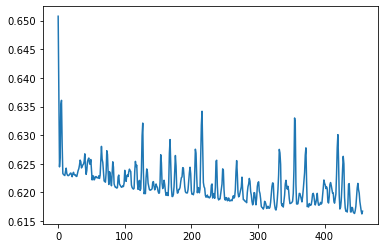

In [10]:

plt.plot(np.asarray(val_loss_g_))
best_model_test_loss_g

array(0.5274386, dtype=float32)

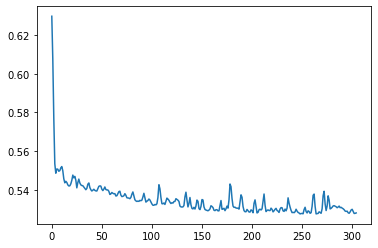

In [11]:

plt.plot(np.asarray(val_loss_q_))
best_model_test_loss_q